# Immunogenicity analysis

We uses the method of removing and/or reducing potential T-cell epitopes, as an approach to the management of the immunogenicity of biologics. The protein sequence is scanned in silico, for sequences that have a strong binding signature for a family of 50 MHC Class II receptors , whose alleles cover 96 – 98% of the human population. The presented histograms for each variable region sequence, show the average (for the n positively-testing MHC II alleles) of epitope strength at each position as a percentage for all epitopes above a threshold of 20%. At each position in the sequence, the number of alleles scoring above the threshold is shown above the histogram at that position. The epitopes of most concern for the antibody’s immunogenicity are therefore those that have not just the highest average score per allele (as shown by the histogram), but which also score above the threshold across more alleles, since these epitopes are more likely to engender an immune response in a larger fraction of the patient population.

Experience using in silico algorithms of this kind in conjunction with laboratory immunogenicity assays has shown that epitopes below this threshold do not generally contribute significantly to the protein’s immunogenicity. The number of alleles, the affected alleles and their individual scores are also listed in the detailed analyses below each histogram figure.

The raw immunogenicity score quoted is the total over all epitopes above the threshold for all affected alleles. The normalized immunogenicity score is this raw score divided by the sequence length, and represents epitope strength per unit sequence to enable comparisons of protein sequences of different lengths.


## MHC class 1

Class I major histocompatibility complex (MHC) molecules bind, and present to T cells, short peptides derived from intracellular processing of proteins. The peptide repertoire of a specific molecule is to a large extent determined by the molecular structure accommodating so-called main anchor positions of the presented peptide.

Their function is to display peptide fragments of proteins from within the cell to cytotoxic T cells; this will trigger an immediate response from the immune system against a particular non-self antigen displayed with the help of an MHC class I protein. Because MHC class I molecules present peptides derived from cytosolic proteins, the pathway of MHC class I presentation is often called cytosolic or endogenous pathway.[^footnote1]

[^footnote1]: Kimball's Biology Pages, Histocompatibility Molecules

- MHC class 1 superset
  - HLA-A01:01, HLA-A02:01, HLA-A03:01, HLA-A24:02, HLA-B07:02, HLA-B40:01 

### Predicts binding of peptides to MHC class1


In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
from Bio import SeqIO
# import epitopepredict as ep
# from epitopepredict import base, sequtils, analysis, plotting
import pandas as pd
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# For Antibody 
record_iterator = SeqIO.parse("../data/sequence.fasta", "fasta")
first_record = next(record_iterator)
second_record = next(record_iterator)

my_seq = str(first_record.seq)
target_name = first_record.name

# !netMHCpan -a HLA-A01:01,HLA-A02:01,HLA-A03:01,HLA-A24:02,HLA-B07:02,HLA-B40:01  -f ./data/sequence.fasta > ./data/MHC1.txt

def mhc1_result(temp):
        """Read raw results from netMHCpan output"""

        cols = ['pos','allele','peptide', 'Core', 'Of', 'Gp','Gl','Ip','Il','Icore',
                'Identity','Score_EL','Rank', "<=", 'Bindlevel']
        ignore = ['Pos','#','Protein','', 'training']
        res = pd.read_csv(temp, comment='#', names=cols, sep='\s+',
                          error_bad_lines=False, skiprows=47).dropna(subset=['peptide'])
        res = res[~res.pos.isin(ignore)]
        res = res[~res.Of.isin(ignore)]
        res = res.drop(columns='<=')
        res = res.astype({"Of":int, "Gp":int, "Gl": int, "Ip":int, "Il": int, 
                          "Score_EL": float, "Rank": float})
        return res
    
df_mhc1 = mhc1_result('../data/MHC1.txt')
df_mhc1_hc, df_mhc1_lc = [x for _, x in df_mhc1.groupby(by='Identity')]

b'Skipping line 1819: expected 15 fields, saw 18\nSkipping line 2651: expected 15 fields, saw 18\nSkipping line 4430: expected 15 fields, saw 18\nSkipping line 5262: expected 15 fields, saw 18\nSkipping line 7041: expected 15 fields, saw 18\nSkipping line 7873: expected 15 fields, saw 18\nSkipping line 9652: expected 15 fields, saw 18\nSkipping line 10484: expected 15 fields, saw 18\nSkipping line 12263: expected 15 fields, saw 18\nSkipping line 13095: expected 15 fields, saw 18\nSkipping line 14874: expected 15 fields, saw 18\nSkipping line 15706: expected 15 fields, saw 18\nSkipping line 17485: expected 15 fields, saw 18\nSkipping line 18317: expected 15 fields, saw 18\nSkipping line 20096: expected 15 fields, saw 18\nSkipping line 20928: expected 15 fields, saw 18\nSkipping line 22707: expected 15 fields, saw 18\nSkipping line 23539: expected 15 fields, saw 18\n'


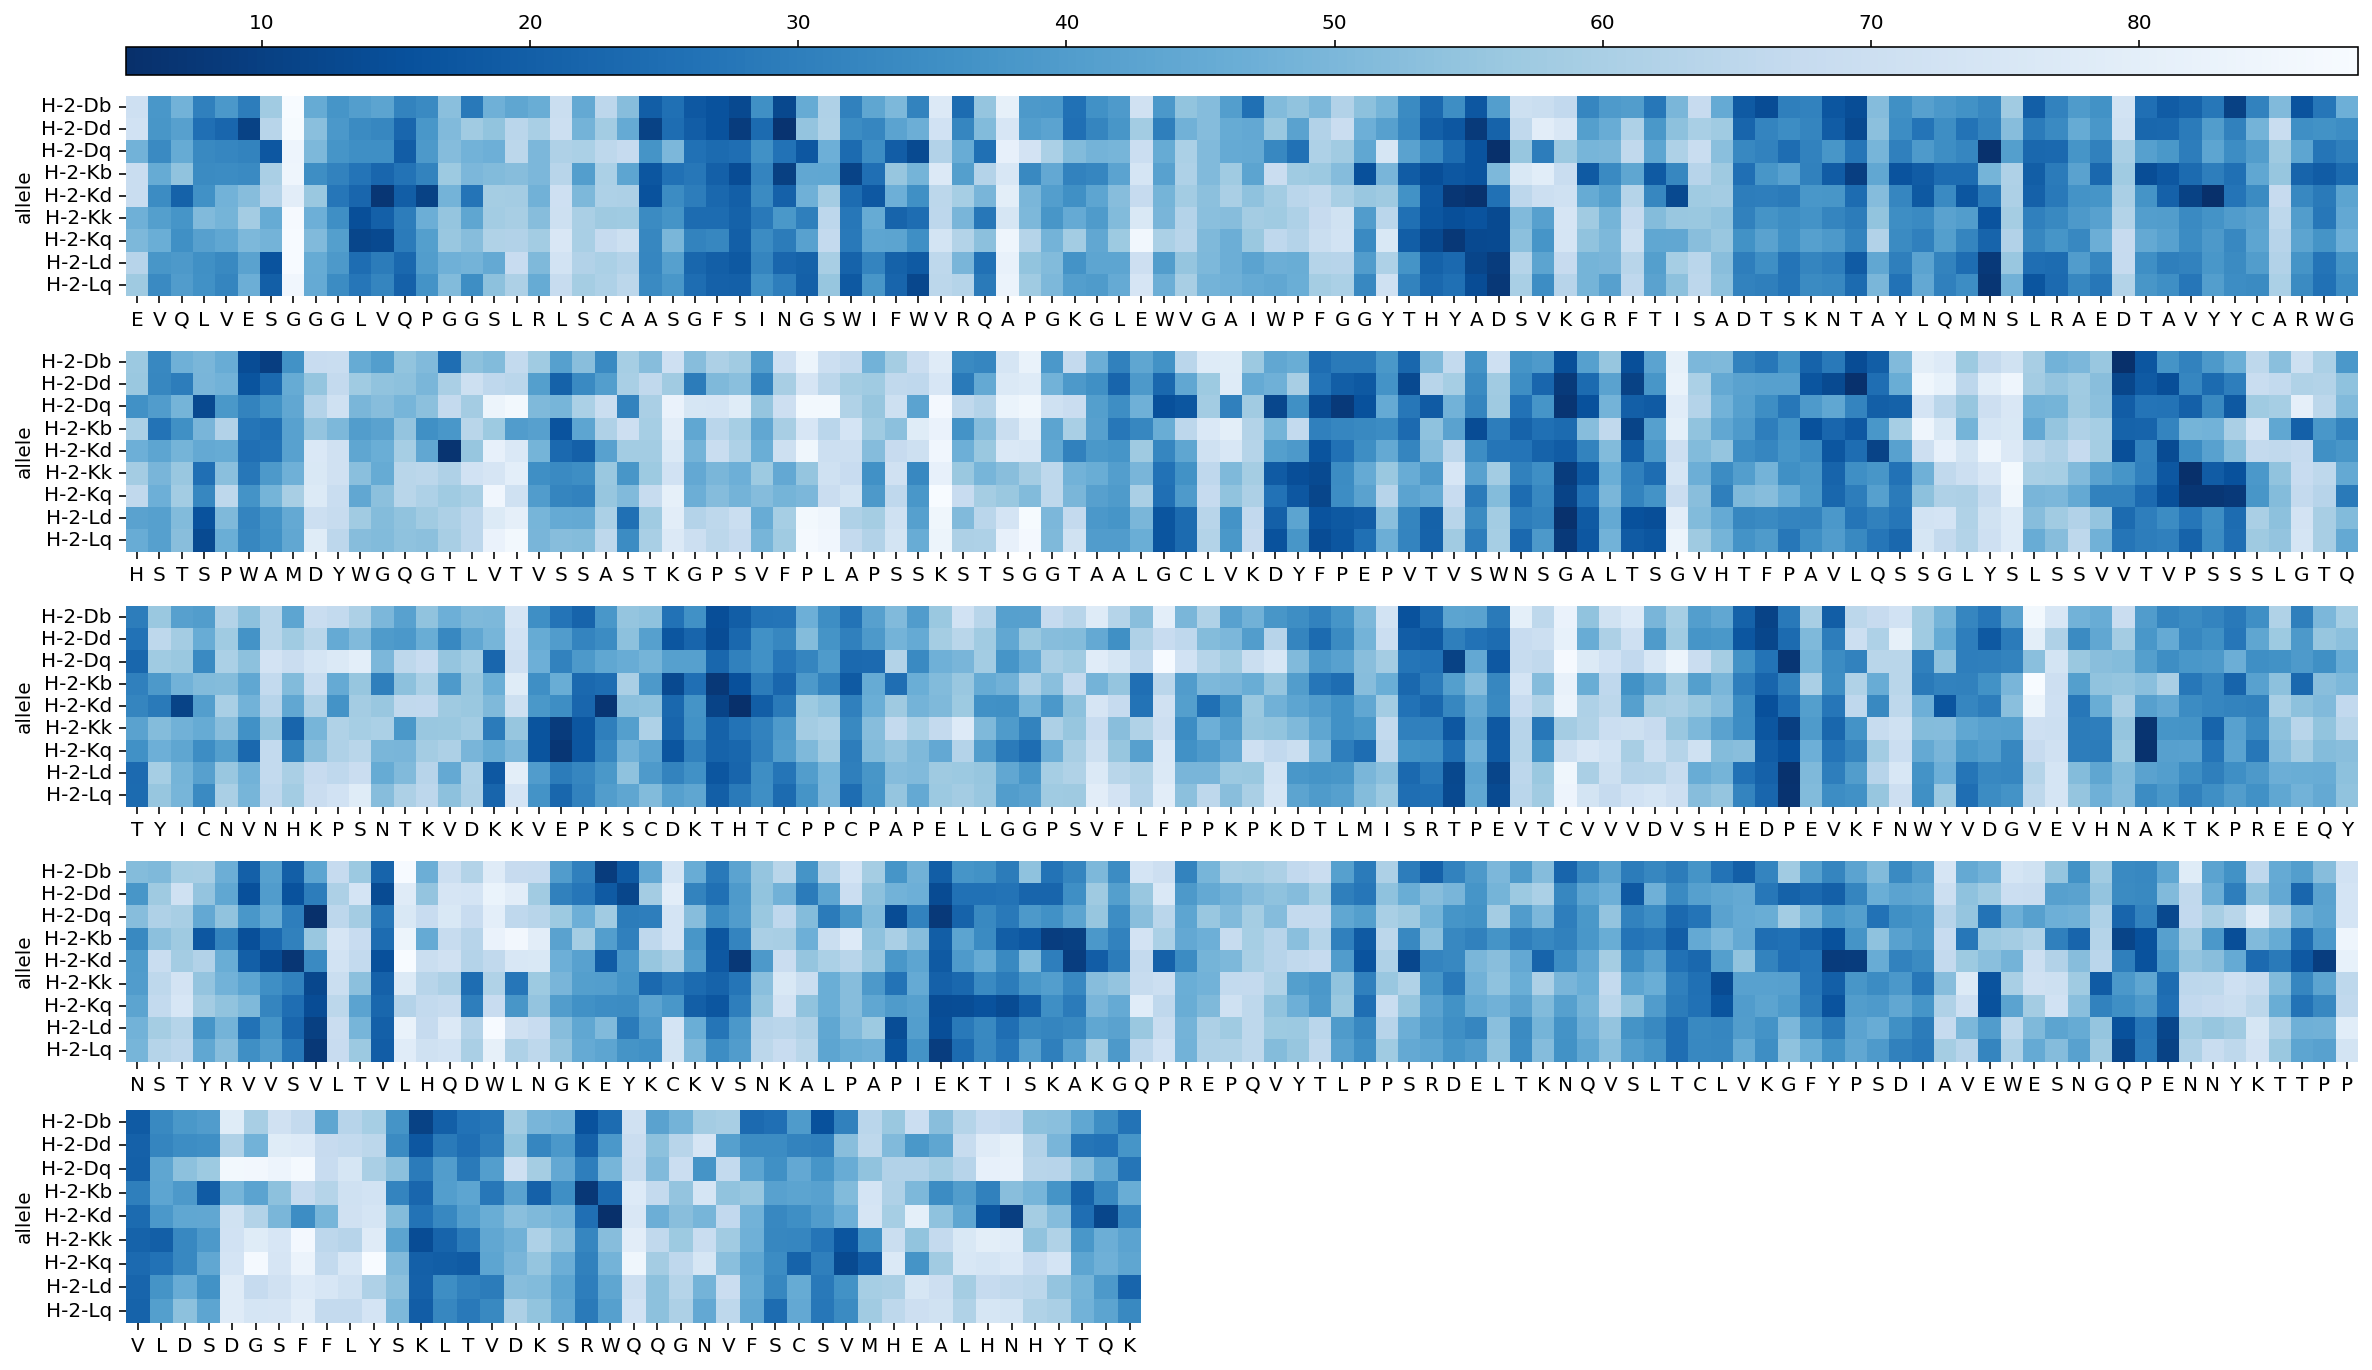

In [2]:
import math
import seaborn as sns 

# chunks_size = 100
# chunks_num = math.ceil(len(my_seq)/chunks_size)

def split_dataframe(df, chunk_size = 10000): 
    num_chunks = len(df) // chunk_size
    if len(df) % chunk_size != 0:
        num_chunks += 1
    for i in range(num_chunks):
        yield df[i*chunk_size:(i + 1) * chunk_size]

def make_table(df, record, chunks_size):
    my_seq = str(record.seq)
    df_pivot = pd.pivot_table(df, index='pos', values='Rank', columns='allele')
    df_pivot.index = list(my_seq[:df_pivot.shape[0]])
    df_list = split_dataframe(df_pivot,chunks_size)
    return df_list

def make_heatmap(df_list, record, mer, size, color, chunks_size):
    my_seq = len(record.seq) - mer
    chunks_num = math.ceil(my_seq/chunks_size)
    f,axs = plt.subplots(chunks_num, 1, figsize=(20, size*chunks_num))
    nrows = chunks_num
    ncols = 1
    for n, data in enumerate(df_list):
        ax = plt.subplot(nrows, ncols, n+1)
        sns.heatmap(data.T,cmap=color,square=True, cbar=False, ax=ax)

    mappable=ax.get_children()[0]    
    plt.colorbar(mappable, ax=axs, location='top', pad=0.01, orientation='horizontal', aspect=80)
    for ax in axs: # for plot alignment to left
        ax.set_anchor('W')
    plt.show()
    
make_heatmap(make_table(df_mhc1_hc, first_record, 100),first_record, 11, 2.7, 'Blues_r', 100)

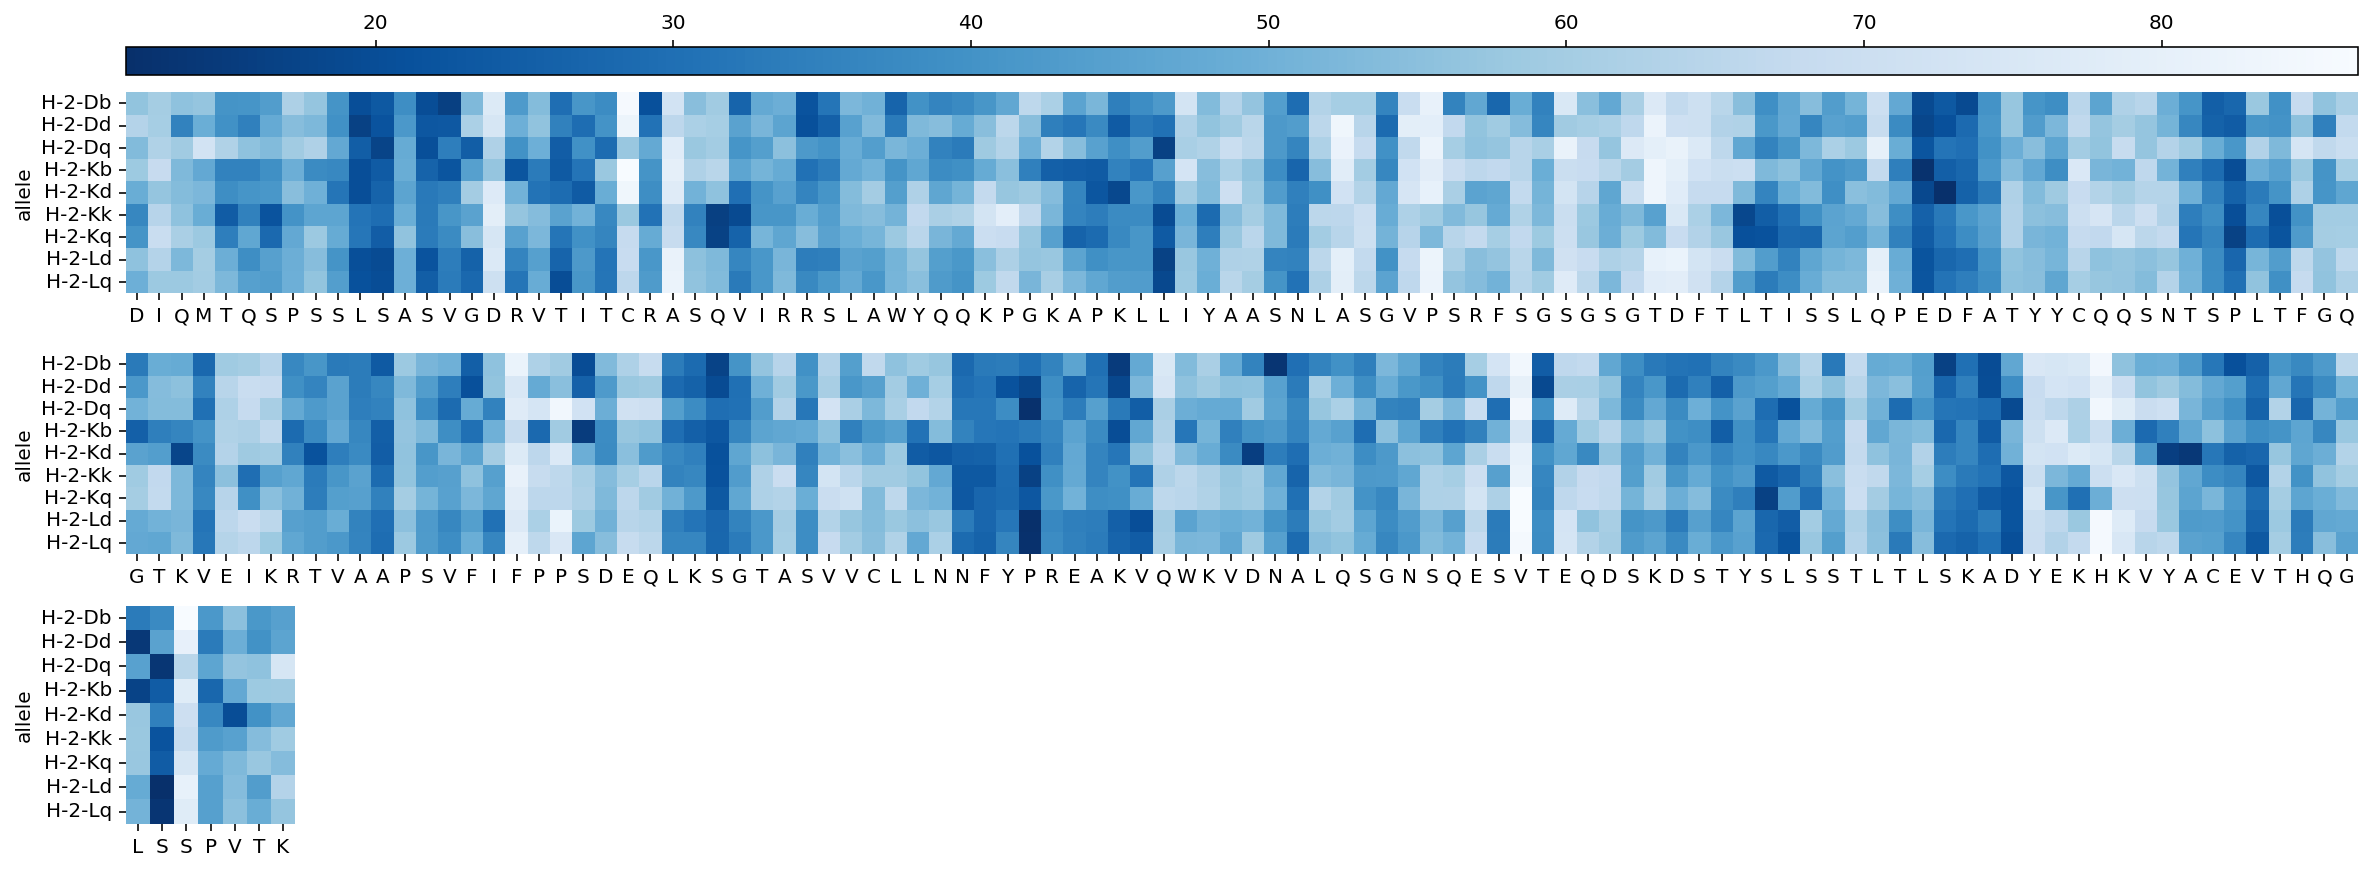

In [3]:
make_heatmap(make_table(df_mhc1_lc, second_record, 100),second_record, 11, 2.7, 'Blues_r',100)

In [4]:
len(first_record.seq)

450

### Top10 strong binding peptide

In [5]:
# df_mhc1_binder = df_mhc1[~df_mhc1['Bindlevel'].isna()]
# strong binder
df_mhc1_binder = df_mhc1[df_mhc1['Bindlevel'] == 'SB']
df_mhc1_binder = df_mhc1_binder[['allele','peptide','Core','Rank']].sort_values(by=['Rank'], ascending=True).reset_index(drop=True)
# df_binder.head(10).style
df_mhc1_pivot = pd.pivot_table(df_mhc1_binder, values=['peptide','allele'], index='Core', aggfunc='count')
df_mhc1_pivot = df_mhc1_pivot.sort_values(by=['allele'], ascending=False)
df_mhc1_pivot.head(10)

,allele,peptide
Core,,
STYSLSSTL,6,6
FPEPVTVSW,4,4
FPPKPKDTL,4,4
YPSDIAVEW,4,4
FPAVLQSSL,3,3
LPAPIEKTI,3,3
SPSSLSASV,3,3
WPFGGYTHY,3,3
KPGKAPKLL,3,3


### Frequency of binding peptide


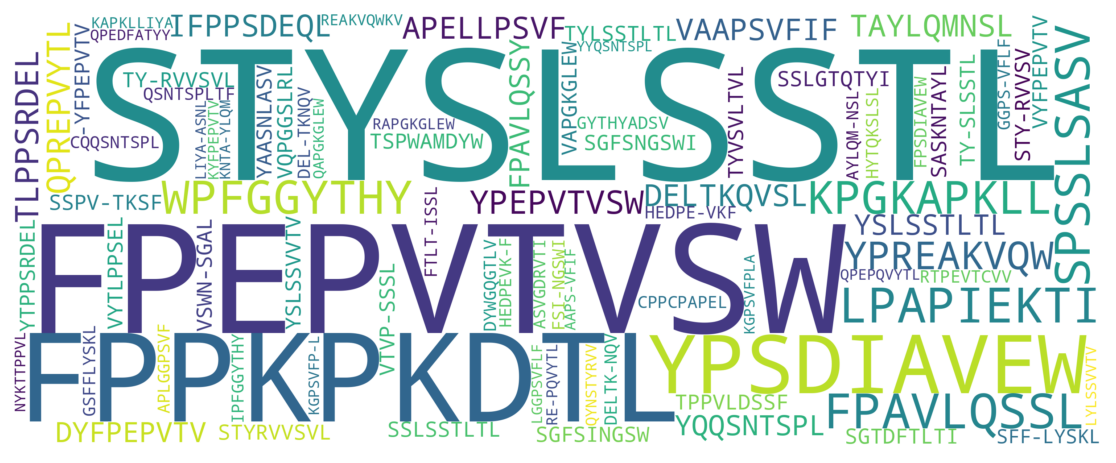

In [6]:
from wordcloud import WordCloud

dic_freq = df_mhc1_pivot.to_dict()['allele']
keywords = dic_freq

wordcloud = WordCloud(
    width = 3000,
    height = 1200,
    background_color="white",
    max_words=1000
)

wordcloud = wordcloud.generate_from_frequencies(keywords)
array = wordcloud.to_array()
fig = plt.figure(figsize=(10,4))
plt.imshow(array, interpolation="bilinear")
plt.axis("off")
plt.show()

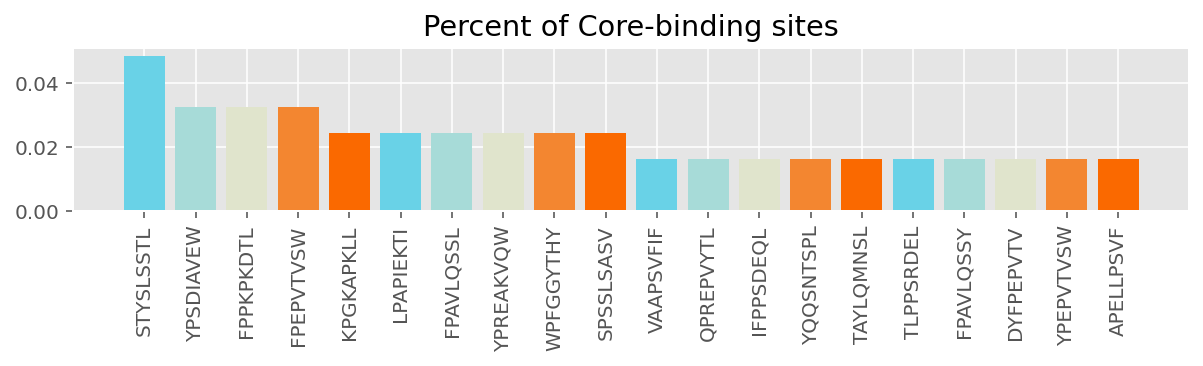

In [7]:
plt.figure(figsize=(10,1.5))
plt.style.use('ggplot')

item_counts = df_mhc1_binder["Core"].value_counts(normalize=True)
allele_counts = df_mhc1_binder["allele"].value_counts(normalize=True)
data = item_counts[:20]
# colors = ['#ECD078', '#D95B43', '#C02942', '#542437', '#53777A'] #Thought Provoking
colors = ['#69D2E7', '#A7DBD8', '#E0E4CC', '#F38630', '#FA6900'] #goldfish

plt.title('Percent of Core-binding sites')
plt.xticks(rotation='vertical')
plt.bar(data.index, data.values, color=colors)
plt.show()

## MHC class 2

MHC Class II molecules are a class of major histocompatibility complex (MHC) molecules normally found only on professional antigen-presenting cells such as dendritic cells, mononuclear phagocytes, some endothelial cells, thymic epithelial cells, and B cells. These cells are important in initiating immune responses.

- MHC class 2 allele superset
  - DRB1_0101,DRB1_0102,DRB1_0103,DRB1_0104,DRB1_0105,DRB1_0106,DRB1_0107,DRB1_0108,DRB1_0109,DRB1_0110

### Predicts binding of peptides to MHC class2 

In [8]:
# !netMHCIIpan -a DRB1_0101,DRB1_0102,DRB1_0103,DRB1_0104,DRB1_0105,DRB1_0106,DRB1_0107,DRB1_0108,DRB1_0109,DRB1_0110  -f ./data/sequence.fasta > ./data/MHC2.txt

def mhc2_result(temp):
        """Read raw results from netMHCIIpan output"""

        ignore = ['Pos','#','Protein','','Number']
        cols = ['pos','allele','peptide', 'Of', 'Core', 'Core_rel', 'Identity','Affinity','Rank','Exp_Bind', 'Bindlevel']
        res = pd.read_csv(temp, comment='#', names=cols, sep='\s+',
                          error_bad_lines=False, skiprows=15).dropna(subset=['peptide'])
        res = res[~res.pos.isin(ignore)]
        res = res.astype({"Of":int, "Core_rel":float, "Affinity": float, "Rank": float})
        return res

df_mhc2 = mhc2_result('../data/MHC2.txt')
# df.head()
df_mhc2_hc, df_mhc2_lc = [x for _, x in df_mhc2.groupby(by='Identity')]

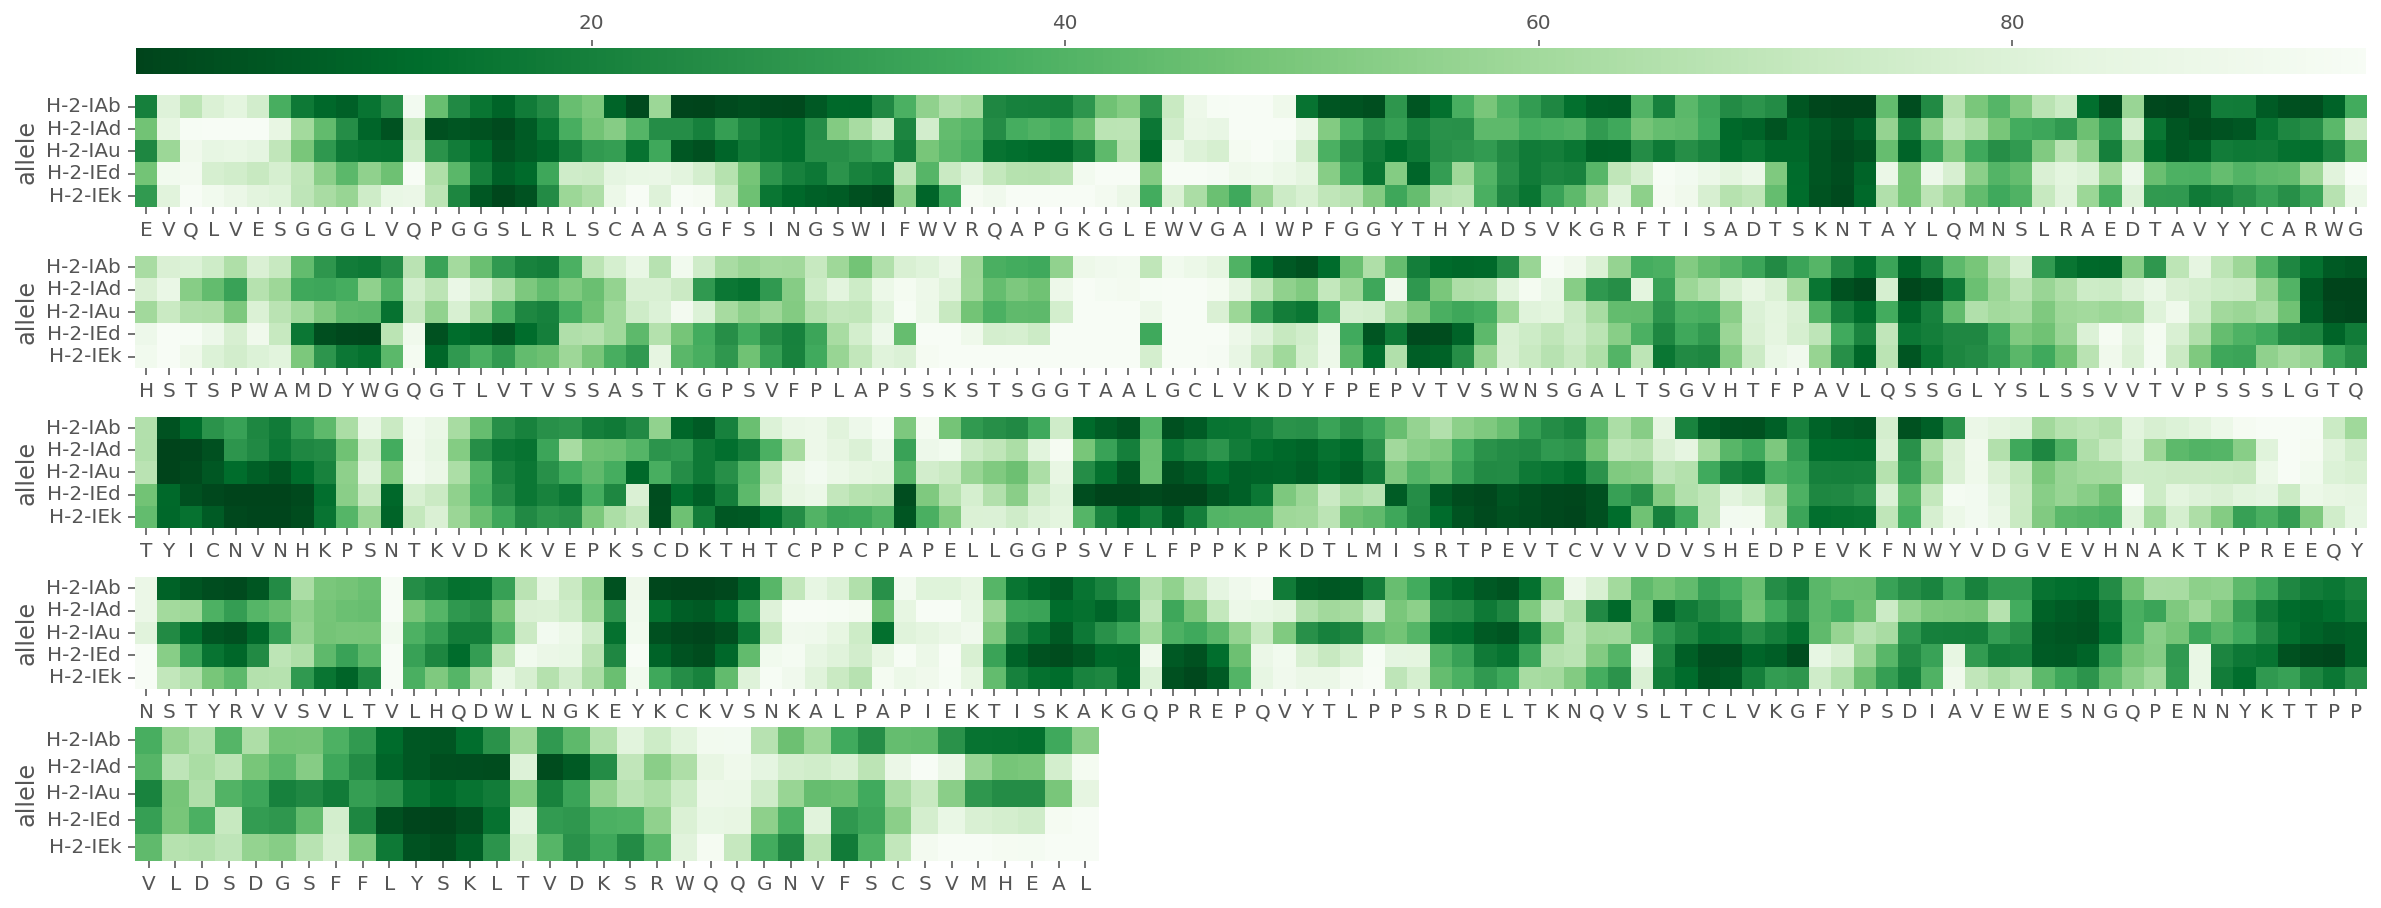

In [9]:
make_heatmap(make_table(df_mhc2_hc,first_record, 100),first_record, 15, 1.7, 'Greens_r', 100)

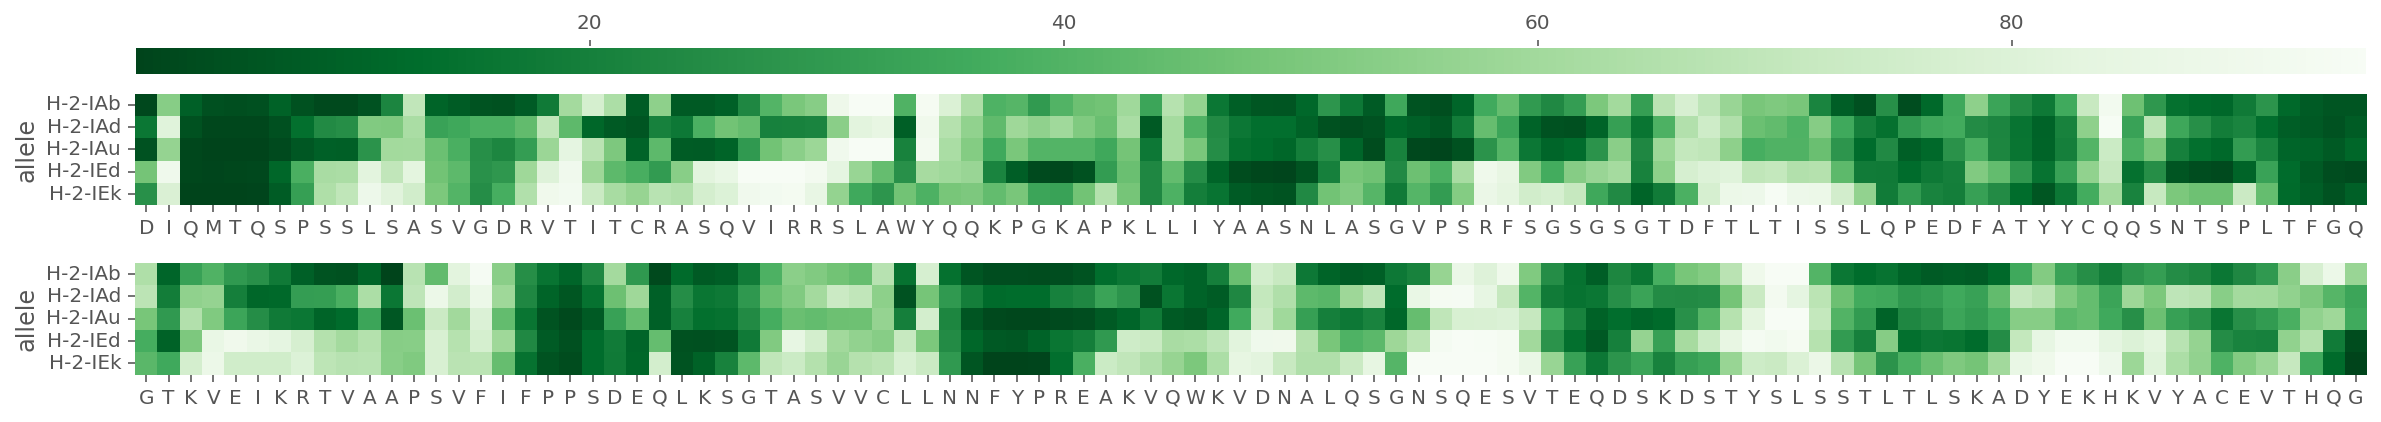

In [10]:
make_heatmap(make_table(df_mhc2_lc, second_record, 100),second_record, 14, 1.7, 'Greens_r', 100)

### Top10 binding peptide

In [11]:
df_mhc2_binder = df_mhc2[~df_mhc2['Bindlevel']. isna()]
# df_binder = df_binder[['allele','peptide','Core','Rank']].sort_values(by=['Rank'], ascending=True).reset_index(drop=True)
# df_binder.head(10)
df_mhc2_pivot = pd.pivot_table(df_mhc2_binder, values='allele', index='Core', aggfunc='count')
df_mhc2_pivot = df_mhc2_pivot.sort_values(by=['allele'], ascending=False)
# displaying the DataFrame
df_mhc2_pivot.head(10).style

,allele
Core,
IKRTVAAPS,17
VDGVEVHNA,10
YKCKVSNKA,10
YKTTPPVLD,9
ISKAKGQPR,8
VHNAKTKPR,8
HTFPAVLQS,6
WKVDNALQS,6
LQSGNSQES,6


### Frequency of binding peptide

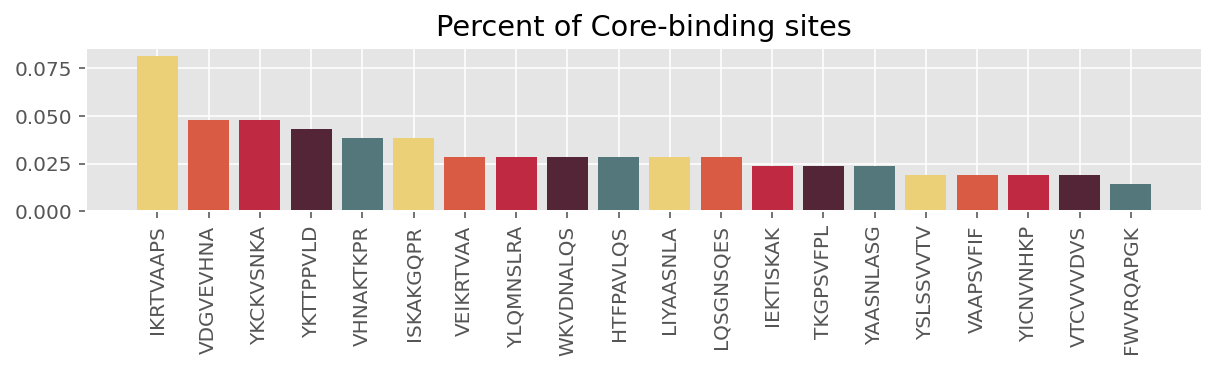

In [12]:
plt.figure(figsize=(10,1.5))
plt.style.use('ggplot')
item_counts = df_mhc2_binder["Core"].value_counts(normalize=True)
allele_counts = df_mhc2_binder["allele"].value_counts(normalize=True)
data = item_counts[:20]
colors = ['#ECD078', '#D95B43', '#C02942', '#542437', '#53777A'] #Thought Provoking

plt.title('Percent of Core-binding sites')
plt.xticks(rotation='vertical')
plt.bar(data.index, data.values, color=colors)
plt.show()

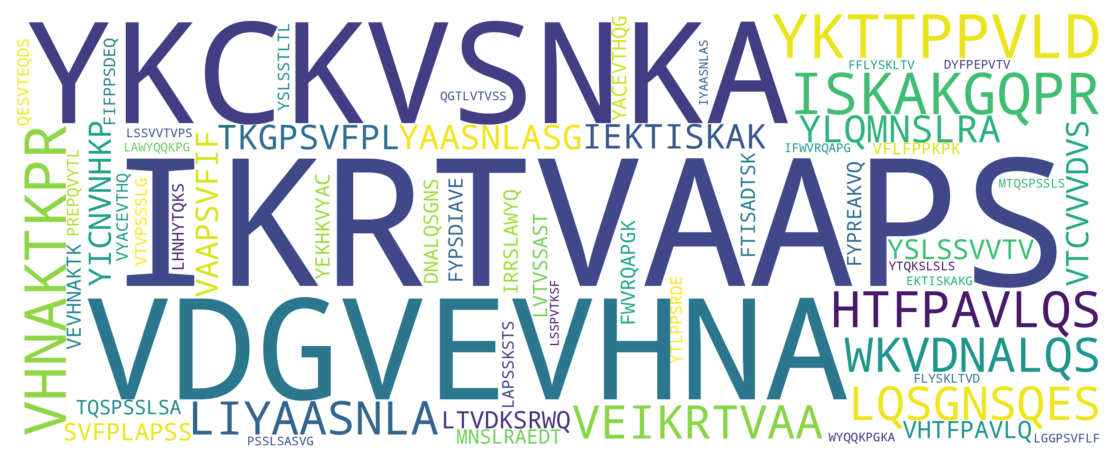

In [13]:
# !pip install wordcloud
from wordcloud import WordCloud

dic_freq = df_mhc2_pivot.to_dict()['allele']
# dic_freq
# keywords = {'이것':5, '예문':3, '단어':5, '빈도수':3}
# keywords.pop('영화')
keywords = dic_freq

wordcloud = WordCloud(
    width = 3000,
    height = 1200,
    background_color="white",
    max_words=1000
)


wordcloud = wordcloud.generate_from_frequencies(keywords)
array = wordcloud.to_array()
fig = plt.figure(figsize=(10,4))
plt.imshow(array, interpolation="bilinear")
plt.axis("off")
plt.show()

## Appendix

nothing yet.

In [14]:
# import biotite.sequence as seq
# import biotite.sequence.align as align
# import numpy as np

# alph = seq.ProteinSequence.alphabet
# # Load the standard protein substitution matrix, which is BLOSUM62
# matrix = align.SubstitutionMatrix.std_protein_matrix()
# print("\nBLOSUM62\n")
# print(matrix)
# # Load another matrix from internal database
# matrix = align.SubstitutionMatrix(alph, alph, "BLOSUM50")
# # Load a matrix dictionary representation,
# # modify it, and create the SubstitutionMatrix
# # (The dictionary could be alternatively loaded from a string containing
# # the matrix in NCBI format)
# matrix_dict = align.SubstitutionMatrix.dict_from_db("BLOSUM62")
# matrix_dict[("P","Y")] = 100
# matrix = align.SubstitutionMatrix(alph, alph, matrix_dict)
# # And now create a matrix by directly provding the ndarray
# # containing the similarity scores
# # (identity matrix in our case)
# scores = np.identity(len(alph), dtype=int)
# matrix = align.SubstitutionMatrix(alph, alph, scores)
# print("\n\nIdentity matrix\n")
# print(matrix)

In [15]:
# seq1 = seq.ProteinSequence("BIQTITE")
# seq2 = seq.ProteinSequence("IQLITE")
# matrix = align.SubstitutionMatrix.std_protein_matrix()
# print("\nLocal alignment")
# alignments = align.align_optimal(seq1, seq2, matrix, local=True)
# for ali in alignments:
#     print(ali)
# print("Global alignment")
# alignments = align.align_optimal(seq1, seq2, matrix, local=False)
# for ali in alignments:
#     print(ali)

In [16]:
# import matplotlib.pyplot as plt
# import biotite.sequence.graphics as graphics

# fig, ax = plt.subplots(figsize=(2.0, 0.8))
# graphics.plot_alignment_similarity_based(
#     ax, alignments[0], matrix=matrix, symbols_per_line=len(alignments[0])
# )
# fig.tight_layout()

In [17]:
# import matplotlib.pyplot as plt
# import biotite.sequence as seq
# import biotite.sequence.align as align
# import biotite.sequence.io.fasta as fasta
# import biotite.database.entrez as entrez
# import biotite.sequence.graphics as graphics

# # Download and parse protein sequences of avidin and streptavidin
# fasta_file = fasta.FastaFile.read(entrez.fetch_single_file(
#     ["CAC34569", "ACL82594"], None, "protein", "fasta"
# ))
# for name, sequence in fasta_file.items():
#     if "CAC34569" in name:
#         avidin_seq = seq.ProteinSequence(sequence)
#     elif "ACL82594" in name:
#         streptavidin_seq = seq.ProteinSequence(sequence)

# # Get BLOSUM62 matrix
# matrix = align.SubstitutionMatrix.std_protein_matrix()
# # Perform pairwise sequence alignment with affine gap penalty
# # Terminal gaps are not penalized
# alignments = align.align_optimal(avidin_seq, streptavidin_seq, matrix,
#                                  gap_penalty=(-10, -1), terminal_penalty=False)

# # Draw first and only alignment
# # The color intensity indicates the similiarity
# fig = plt.figure(figsize=(8.0, 2.5))
# ax = fig.add_subplot(111)
# graphics.plot_alignment_similarity_based(
#     ax, alignments[0], matrix=matrix, labels=["Avidin", "Streptavidin"],
#     show_numbers=True, show_line_position=True
# )
# fig.tight_layout()

# plt.show()